In [1]:
import sys
import csv
import re
import pprint
import fastText
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score
from bs4 import BeautifulSoup
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [2]:
# Test parts for data preparation; not used eventually
# from nltk.corpus import stopwords
# stop_words = stopwords.words("dutch")
#         tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)", " ", tweet).split()) # remove hastags and mentions
#         tweet = ' '.join(re.sub("[\'\.\,\!\?\:\;\-\=\(\)\[\]\{\}\\\<\>\/\?\@\#$#\%\^\&\*\_\~\"]", " ", tweet).split()) # remove punctuation
#         tweet = remove_emoji(tweet)
#     df["cleaned"] = df["cleaned"].str.split()
#     df["cleaned"].apply(lambda x: [item for item in x if item not in stop_words]) # remove stopwords
#     df["cleaned"] = [" ".join(x) for x in df["cleaned"]]

# Prepare data

In [9]:
def preprocess(df):
    df["cleaned"] = ""
    tweets = []
    for tweet in df["text"]:
        tweet = BeautifulSoup(tweet).get_text() # transforms things like &amp to &
        tweet = tweet.lower()
        tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)", "MENTION", tweet).split()) # replace mentions with "MENTION"
        tweet = ' '.join(re.sub("#", " ", tweet).split()) # remove # symbols    
        tweet = ' '.join(re.sub("(\w+:\/\/\S+)", "URL", tweet).split()) # replace links/URLs with "URL"
        tweets.append(tweet)
         
    df["cleaned"] = tweets

    return df["cleaned"]

def replacer(input_file):
    df = pd.read_csv(input_file, sep='\t', encoding="utf8")
    df["cleaned"] = preprocess(df) # add processed text to a new column "cleaned" and add this to the dataframe
    
    # replace all EXPLICIT and IMPLICIT labels with OFFENSIVE
    df["explicitness"] = df["explicitness"].replace(["EXPLICIT", "IMPLICIT"], "OFFENSIVE")

    print(df["explicitness"].value_counts())
    
    # transform labels with LabelEncoder
    # 0 = NOT
    # 1 = OFFENSIVE
    df["explicitness"] = df["explicitness"].astype(str)
    df["explicitness"] = LabelEncoder().fit_transform(df["explicitness"])

    return df       

In [10]:
print("Train:")
train_df = replacer("https://raw.githubusercontent.com/Zhenjaah/thesis/main/data/train_final.csv")

print("Dev:")
dev_df = replacer("https://raw.githubusercontent.com/Zhenjaah/thesis/main/data/dev_final.csv")

print("Test:")
test_df = replacer("https://raw.githubusercontent.com/Zhenjaah/thesis/main/data/test_final.csv")

print(train_df["text"].head())
print(train_df["cleaned"].head())

Train:
NOT          5176
OFFENSIVE    2588
Name: explicitness, dtype: int64
Dev:
NOT          361
OFFENSIVE    186
Name: explicitness, dtype: int64
Test:
NOT          2072
OFFENSIVE    1037
Name: explicitness, dtype: int64
0    @StuiverAnne @LodewijkA Iets anders, wanneer w...
1    @GUnight fucking schaamteloos! Je kunt de Afri...
2    Mijn hemel! De elite, diegenen die onze cultuu...
3    het feit dat mensen nog steeds zwarte piet sup...
4    @GerardKrolNL @groenlinks het is goed te zien ...
Name: text, dtype: object
0    MENTION MENTION iets anders, wanneer word assc...
1    MENTION fucking schaamteloos! je kunt de afrik...
2    mijn hemel! de elite, diegenen die onze cultuu...
3    het feit dat mensen nog steeds zwarte piet sup...
4    MENTION MENTION het is goed te zien dat grlink...
Name: cleaned, dtype: object


In [4]:
# vectorize words using tf_idf for SVM
tf_idf = TfidfVectorizer()
# print(tf_idf.get_feature_names())
X_train = pd.DataFrame(tf_idf.fit_transform(train_df["cleaned"]).toarray())

tf_idf2 = TfidfVectorizer(vocabulary = tf_idf.get_feature_names())
X_test = pd.DataFrame(tf_idf2.fit_transform(test_df["cleaned"]).toarray())

print(X_train.shape)
print(X_test.shape)

(7764, 20956)
(3109, 20956)


# Apply LinearSVC

In [8]:
np.random.seed(1)

y_train = train_df["explicitness"].copy()

y_test = test_df["explicitness"].copy()

model = svm.LinearSVC(loss="hinge")

model.fit(X_train, y_train)
print(model.score(X_test, y_test)) # 0.8128015439047925

f1_score(y_test, model.predict(X_test), average='macro')
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

0.8128015439047925
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      2072
           1       0.79      0.59      0.68      1037

    accuracy                           0.81      3109
   macro avg       0.81      0.76      0.77      3109
weighted avg       0.81      0.81      0.80      3109



[[1910  162]
 [ 420  617]]


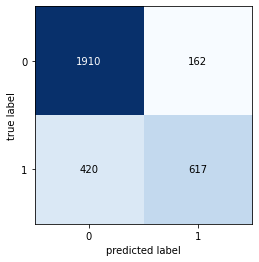

In [6]:
y_target = y_test
y_predicted = y_pred

cm = confusion_matrix(y_target=y_target, 
                      y_predicted=y_predicted)
print(cm)

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

# Add prefix to work with fasttext

In [8]:
def add_prefix(dataframe, output_file):

    f_rows = []

    # add required prefix for fasttext
    for index, row in dataframe.iterrows():
        fasttext_row = f"{'__label__' + str(row['explicitness'])} {row['cleaned']}"
        f_rows.append(fasttext_row)
        
    fasttext_df = pd.DataFrame(f_rows)
    
    return fasttext_df.to_csv(output_file, index=False, header=False, encoding="utf-8", 
                              quoting = csv.QUOTE_NONE, quotechar = "", escapechar = " ")

In [9]:
print("Adding prefixes to data...")
fasttext_df_train = add_prefix(train_df, 'train.txt')
fasttext_df_dev = add_prefix(dev_df, 'dev.txt')
fasttext_df_test = add_prefix(test_df, 'test.txt')
print("Done!")

Adding prefixes to data...
Done!


# Train fasttext model

In [2]:
# print("Training fasttext model...")
# f_model = fastText.train_supervised(input="train.txt",  
#                                     autotuneValidationFile="dev.txt", 
#                                     autotuneMetric="f1:__label__1", 
#                                     autotuneDuration=900)
# print("Done! Saving the model now...")
# f_model.save_model("fasttext_model_binary.bin")
# print("The model is saved as 'fasttext_model_binary.bin'.")

print("Loading fasttext model...")
f_model = fastText.load_model("fasttext_model_binary.bin")
print("Model loaded succesfully!")

# the part below is used to print out the arguments of the autotunoValidation
args_obj = f_model.f.getArgs()
for hparam in dir(args_obj):
    if not hparam.startswith('__'):
        print(f"{hparam} -> {getattr(args_obj, hparam)}")
        
# f_model_tuned = fastText.train_supervised(input="train.txt", 
#                                          bucket=103348,
#                                          dim=375,
#                                          epoch=5,
#                                          label='__label__',
#                                          loss='softmax',
#                                          lr = 0.05,
#                                          lrUpdateRate=100,
#                                          maxn=6,
#                                          minCount=1,
#                                          minn=3,
#                                          neg=5,
#                                          thread=12,
#                                          seed=0,
#                                          t=0.0001,
#                                          verbose=2,
#                                          wordNgrams=2,
#                                          ws=5)
# f_model_tuned.save_model("fasttext_model_binary_tuned.bin")
# print("The model is saved as 'fasttext_model_binary_tuned.bin'.")

# f_model_tuned = fastText.load_model("fasttext_model_binary_tuned.bin")
# print("Model loaded succesfully!")

Loading fasttext model...
Model loaded succesfully!
autotuneDuration -> 300
autotuneMetric -> f1
autotuneModelSize -> 
autotunePredictions -> 1
autotuneValidationFile -> 
bucket -> 103348
cutoff -> 0
dim -> 375
dsub -> 2
epoch -> 5
input -> 
label -> __label__
loss -> loss_name.softmax
lr -> 0.05
lrUpdateRate -> 100
maxn -> 6
minCount -> 1
minCountLabel -> 0
minn -> 3
model -> model_name.supervised
neg -> 5
output -> 
pretrainedVectors -> 
qnorm -> False
qout -> False
retrain -> False
saveOutput -> False
seed -> 0
setManual -> <bound method PyCapsule.setManual of <fasttext_pybind.args object at 0x000001ECB4486130>>
t -> 0.0001
thread -> 12
verbose -> 2
wordNgrams -> 2
ws -> 5


In [8]:
f_model.get_nearest_neighbors("halsema")

[(0.9999922513961792, 'halalsema'),
 (0.9999881982803345, 'gorelinksehalsema'),
 (0.9999875426292419, 'femkehalsema'),
 (0.9999857544898987, 'halsema!'),
 (0.9999817609786987, 'halsema:'),
 (0.9999811053276062, 'neger'),
 (0.9999808669090271, 'domme'),
 (0.9999808073043823, 'shit'),
 (0.9999802112579346, 'halalsema!'),
 (0.9999796152114868, 'idioot')]

In [9]:
# get all labels with probability higher or equal to 0.5
test_sentence = "wij zijn een stel idioten"
f_model.predict(test_sentence,  k=-1, threshold=0.5)

(('__label__1',), array([1.00001001]))

# Test model on reddit comments

In [13]:
reddit_df = pd.read_csv("reddit_comments.csv", sep=',', encoding="utf8")

preprocess(reddit_df)

reddit_df_test = add_prefix(reddit_df, 'reddit_test_data.txt')

In [14]:
def fasttext_model_test(input_file):

    predictions = []

    with open(input_file, encoding="utf8") as f:
        for line in f:
            # check the text, ignore label if label == nan
            test_sentence = line[14:].rstrip()
            predictions.append(f_model.predict(test_sentence,  k=-1, threshold=0.5))

    return predictions, test_sentence 

In [15]:
test = fasttext_model_test("reddit_test_data.txt")

reddit_df["explicitness"] = [str(label[0])[2:-3] for label in test[0]]
reddit_df[["explicitness", "text"]].to_csv("reddit_test_with_labels.txt", index=False, header=False, encoding="utf-8", 
                              quoting = csv.QUOTE_NONE, quotechar = "", escapechar = " ", sep =" ")
reddit_df["explicitness"] = reddit_df["explicitness"].replace(["__label__1"], "OFFENSIVE")
reddit_df["explicitness"] = reddit_df["explicitness"].replace(["__label__0"], "NOT")

print(reddit_df["explicitness"])

0      OFFENSIVE
1      OFFENSIVE
2            NOT
3      OFFENSIVE
4            NOT
         ...    
520          NOT
521          NOT
522          NOT
523          NOT
524          NOT
Name: explicitness, Length: 525, dtype: object


In [21]:
# __label__0 = NOT
# __label__1 = OFFENSIVE

# The precision is the number of correct labels among the labels predicted by fastText. 
# The recall is the number of labels that successfully were predicted, among all the real labels.

results = f_model.test_label("test.txt")
print("Results per label:")
pprint.pprint(results)

# {'__label__0': {'f1score': 0.8692994828396803,
#                 'precision': 0.8473877176901925,
#                 'recall': 0.8923745173745173},
#  '__label__1': {'f1score': 0.7166156982670744,
#                 'precision': 0.7591792656587473,
#                 'recall': 0.6785714285714286}}

Results per label:
{'__label__0': {'f1score': 0.8692994828396803,
                'precision': 0.8473877176901925,
                'recall': 0.8923745173745173},
 '__label__1': {'f1score': 0.7169042769857433,
                'precision': 0.7594390507011867,
                'recall': 0.6788813886210222}}
